In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
#from matplotlib import cm2
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [2]:
pgroup='p21533'
runnumber = 11
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
jsonfile

run: 0011


'/sf/alvra/data/p21533/raw/run0011-FeOX_XANES/meta/scan.json'

In [3]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122
#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

#(DataFluo, Izero, correlation, Energy_eV) = \
#XAS_scan_1diode_static(scan, detector_XAS, detector_Izero, quantile_corr)

(DataFluo1, DataFluo2, IzeroFEL, correlation1, correlation2, Energy_eV) = \
 XAS_scan_2diodes_static(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)

Processing: run0011-FeOX_XANES
Step 104 of 104: Processing acq0104

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet      501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY    468 / 501 -> 7% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 468 / 501 -> 7% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
234 shots out of 468 survived
234 shots out of 468 survived
Step 104 of 104: Processed acq0104
correlation Diode1 (all shots) = 0.996376309114338
correlation Diode2 (all shots) = 0.9961737072136991
------------------------------
Processed 104 out of 104 files


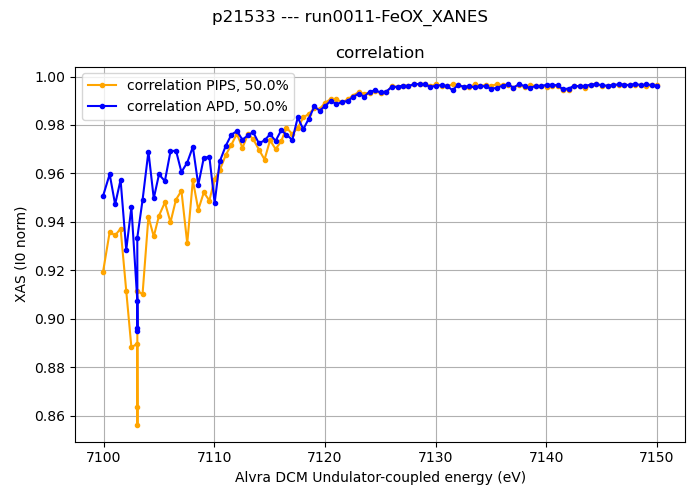

In [4]:
plt.figure(figsize = (7,5))
plt.suptitle(titlestring, fontsize = 12)

XAS1 = DataFluo1[:,0]
err_low1 = DataFluo1[:,1]
err_high1 = DataFluo1[:,2]

XAS2 = DataFluo2[:,0]
err_low2 = DataFluo2[:,1]
err_high2 = DataFluo2[:,2]

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

#plt.plot(Energy_eV, XAS1, label='{}, {}%'.format('fluo PIPS', quantile_corr*100),marker='.', color = 'orange')
#plt.fill_between(Energy_eV, err_low1, err_high1, color='navajowhite')
plt.plot(Energy_eV, correlation1, label='{}, {}%'.format('correlation PIPS', quantile_corr*100),marker='.', color = 'orange')

# plt.plot(Energy_eV, XAS2, label='{}, {}%'.format('fluo APD', quantile_corr*100),marker='.', color = 'blue')
# plt.fill_between(Energy_eV, err_low2, err_high2, color='lightblue')
plt.plot(Energy_eV, correlation2, label='{}, {}%'.format('correlation APD', quantile_corr*100),marker='.', color = 'blue')


plt.xlabel("{} ({})".format(label, units))
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('correlation')
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

#plt.savefig(savedir+'/XANES_RhAcac.png')

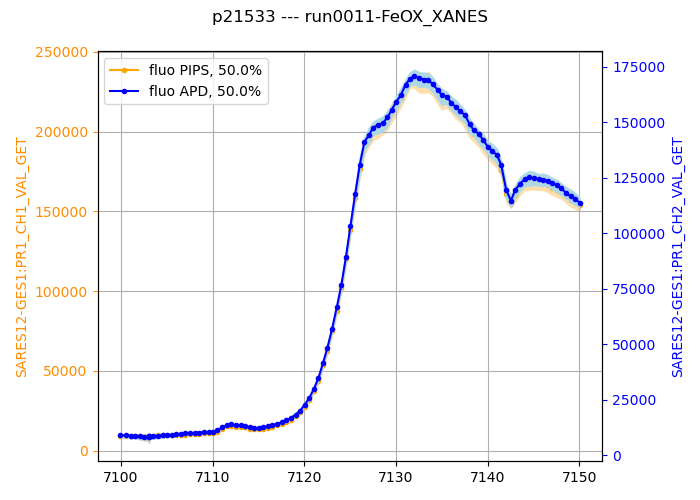

In [5]:
fig = plt.figure(figsize = (7,5))
plt.suptitle(titlestring, fontsize = 12)

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

lns1 = ax1.plot(Energy_eV, XAS1, label='{}, {}%'.format('fluo PIPS', quantile_corr*100),marker='.', color = 'orange')
ax1.fill_between(Energy_eV, err_low1, err_high1, color='navajowhite')

lns2 = ax2.plot(Energy_eV, XAS2, label='{}, {}%'.format('fluo APD', quantile_corr*100),marker='.', color = 'blue')
ax2.fill_between(Energy_eV, err_low2, err_high2, color='lightblue')

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')

ax1.set_ylabel(channel_diode_1)
ax1.tick_params(axis='y', colors='darkorange')
ax1.yaxis.label.set_color('darkorange')

ax2.set_ylabel(channel_diode_2)
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')

plt.tight_layout()
plt.xlabel("{} ({})".format(label, units))
ax1.grid()



## Check correlation for a certain energy point

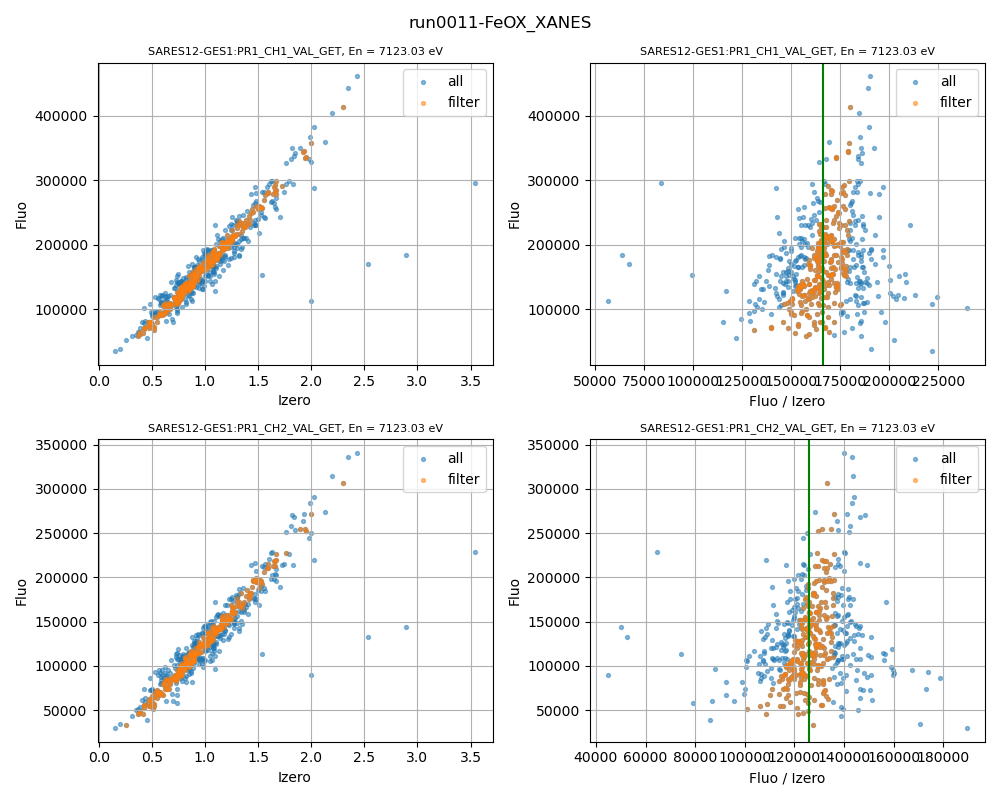

In [6]:
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
Energy_eV = scan.readbacks

chosen_energy = 7123

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

quantile_corr = 0.5
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

(Fluo, Izero, Fluo_filter, Izero_filter) = \
Get_correlation_from_scan_static(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.suptitle(jsonfile.split('/')[-3], fontsize = 12)

ax[0][0].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax[0][0].scatter(Izero, Fluo, s=8, alpha = 0.5,  label = 'all')
ax[0][0].scatter(Izero_filter, Fluo_filter, s=8, alpha = 0.5, label='filter')
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel('Izero')
ax[0][0].set_ylabel('Fluo')
ax[0][0].grid()

m_median_filter = np.median(Fluo_filter/Izero_filter)

ax[0][1].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax[0][1].scatter(Fluo/Izero, Fluo, s=8, alpha = 0.5,  label = 'all')
ax[0][1].scatter(Fluo_filter/Izero_filter, Fluo_filter, s=8, alpha = 0.5, label='filter')
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel('Fluo / Izero')
ax[0][1].set_ylabel('Fluo')
ax[0][1].axvline(x=m_median_filter, color = 'green')
ax[0][1].grid()

#################################################################

detector_XAS = channel_diode_2

#################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

(Fluo, Izero, Fluo_filter, Izero_filter) = \
Get_correlation_from_scan_static(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

ax[1][0].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax[1][0].scatter(Izero, Fluo, s=8, alpha = 0.5,  label = 'all')
ax[1][0].scatter(Izero_filter, Fluo_filter, s=8, alpha = 0.5, label='filter')
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel('Izero')
ax[1][0].set_ylabel('Fluo')
ax[1][0].grid()

m_median_filter = np.median(Fluo_filter/Izero_filter)

ax[1][1].set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax[1][1].scatter(Fluo/Izero, Fluo, s=8, alpha = 0.5,  label = 'all')
ax[1][1].scatter(Fluo_filter/Izero_filter, Fluo_filter, s=8, alpha = 0.5, label='filter')
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel('Fluo / Izero')
ax[1][1].set_ylabel('Fluo')
ax[1][1].axvline(x=m_median_filter, color = 'green')
ax[1][1].grid()

plt.tight_layout()